<a href="https://colab.research.google.com/github/alessio76/Progetto-ML/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  GridSearchCV, ParameterGrid, train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

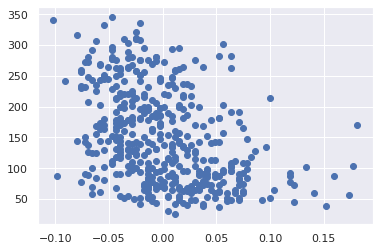

In [ ]:
x,y = load_diabetes()["data"], load_diabetes()["target"]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.2, random_state=1)
plt.scatter(x[:,6], y)

In [ ]:
#overfitting già per i = 3, è meglio quello di grado 1
def grid_search(training_set, param_grid, n_folds, training_labels, first_transformer, second_transformer, score_method): 
 
 test_regressor = make_pipeline(first_transformer, second_transformer)
 grid_search_cv = GridSearchCV(test_regressor, param_grid, scoring = score_method)
 grid_search_cv.fit(training_set,training_labels)
 print('Combinazione migliore:\n', grid_search_cv.best_params_)
 print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)
 regressor = test_regressor.set_params(**grid_search_cv.best_params_)
 regressor.fit(training_set, training_labels)
 return regressor

In [ ]:
def scoring(training_set, test_set, trainig_labels, test_labels,model):
 y_pred = model.predict(training_set)
 print(np.sqrt(mean_squared_error(train_y, y_pred)), model.score(training_set, trainig_labels))
 y_pred = model.predict(test_set)
 print(np.sqrt(mean_squared_error(test_y, y_pred)), model.score(test_set, test_labels))

In [ ]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
  
    def __init__(self, N = None, width_factor=2.0, centers_ = None):
        self.N = N
        self.width_factor = width_factor
        self.centers_ = centers_
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
                
param_grid = {'gaussianfeatures__N' : list(range(2,30))}
gauss_model = grid_search(train_x, param_grid, 5, train_y, GaussianFeatures(), LinearRegression() , 'neg_root_mean_squared_error')
param_grid = {'lasso__alpha' : list(np.logspace(-2, 3, 30))}
lasso_gauss_model = grid_search(train_x, param_grid, 5, train_y, gauss_model.named_steps["gaussianfeatures"], Lasso(normalize= True) , 'neg_root_mean_squared_error')
gauss_model.fit(train_x, train_y) 
scoring(train_x, test_x, train_y, test_y, gauss_model)
print(gauss_model.named_steps)

Combinazione migliore:
 {'gaussianfeatures__N': 4}
Accuratezza media della combinazione migliore: -68.057
Combinazione migliore:
 {'lasso__alpha': 0.04893900918477494}
Accuratezza media della combinazione migliore: -67.950
67.0471333353812 0.2598732162566537
62.8257148929287 0.2593183662358878
{'gaussianfeatures': GaussianFeatures(N=4,
                 centers_=array([-0.13776723, -0.02558215,  0.08660292,  0.19878799]),
                 width_factor=2.0), 'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}


In [ ]:
param_grid = {'gaussianfeatures__N' : list(range(2,30))}
gauss_model = grid_search(train_x, param_grid, 5, train_y, GaussianFeatures(), LinearRegression() , 'neg_root_mean_squared_error')
param_grid = {'ridge__alpha' : list(np.logspace(-2, 3, 30))}
lasso_gauss_model = grid_search(train_x, param_grid, 5, train_y, gauss_model.named_steps["gaussianfeatures"], Ridge(normalize= True) , 'neg_root_mean_squared_error')
gauss_model.fit(train_x, train_y) 
scoring(train_x, test_x, train_y, test_y, gauss_model)
print(gauss_model.named_steps)

Combinazione migliore:
 {'gaussianfeatures__N': 4}
Accuratezza media della combinazione migliore: -68.057
Combinazione migliore:
 {'ridge__alpha': 0.01}
Accuratezza media della combinazione migliore: -68.007
67.0471333353812 0.2598732162566537
62.8257148929287 0.2593183662358878
74.54500760664473 0.08508063529456122
46996.45473106322 -414463.0746100788
77.93403343880536 0.0
73.26046048581938 -0.007154241099143865
77.93263346114367 3.592692500509198e-05
73.25642101670869 -0.00704317828960499
{'gaussianfeatures': GaussianFeatures(N=4,
                 centers_=array([-0.13776723, -0.02558215,  0.08660292,  0.19878799]),
                 width_factor=2.0), 'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}


In [ ]:
#baseline
baseline_regressor = LinearRegression(normalize = True)
baseline_regressor.fit(train_x, train_y)
scoring(train_x, test_x, train_y, test_y, baseline_regressor)

53.245051658083455 0.533228642689112
54.704274800539544 0.4384360401733268


In [ ]:
param_grid = {'polynomialfeatures__degree' : list(range(2,7))}
regressor = grid_search(train_x,param_grid, 5, train_y, PolynomialFeatures(), LinearRegression(normalize = True), 'neg_root_mean_squared_error')
param_grid = {'ridge__alpha' : list(np.logspace(-2, 3, num = 30, base = 10))}
regressor = grid_search(train_x,param_grid, 5, train_y, regressor.named_steps["polynomialfeatures"], Ridge(normalize = True), 'neg_root_mean_squared_error')
scoring(train_x, test_x, train_y, test_y, regressor)

Combinazione migliore:
 {'polynomialfeatures__degree': 2}
Accuratezza media della combinazione migliore: -63.651
Combinazione migliore:
 {'ridge__alpha': 0.16102620275609392}
Accuratezza media della combinazione migliore: -54.934
49.21397850945439 0.6012298483297926
59.90076046853398 0.32668022504402583


In [ ]:
param_grid = {'ridge__alpha' : list(np.logspace(-2, 3, 30))}
model = grid_search(train_x,param_grid, 5, train_y, None, Ridge(normalize = True, random_state = 0), 'neg_root_mean_squared_error')
scoring(train_x, test_x, train_y, test_y, model)

Combinazione migliore:
 {'ridge__alpha': 0.10826367338740546}
Accuratezza media della combinazione migliore: -55.216
53.47769993970167 0.5291407211085754
54.99750185733248 0.4323996903552376


In [ ]:
param_grid = {'lasso__alpha' : list(np.logspace(-2, 3, 30))}
model2 = grid_search(train_x,param_grid, 5, train_y, None, Lasso(normalize = True, random_state = 0), 'neg_root_mean_squared_error')
scoring(train_x, test_x, train_y, test_y, model2)

Combinazione migliore:
 {'lasso__alpha': 0.04893900918477494}
Accuratezza media della combinazione migliore: -55.286
53.41028307172585 0.5303271539158122
55.011234645742576 0.4321161971834744
